In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


# 4 Function minimization

At this week's lecture we discussed how learning a set of parameters can be treated as the task of minimizing an error function. Scipy privides a number of ways of finding minima of functions. We'll test one of them.

In [2]:
import numpy
from scipy.optimize import fmin_bfgs, fmin

The function `fmin_bfgs` uses the method called 
[BFGS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm).
We need to give it the following arguments:
- f: the function to minimize
- x0: the initial guess of the argument with respect to which we're minimizing
- fprime: the first derivative of f. If we omit it, `fmin_bfgs` will use a numerical approximatiom

For example, consider the following polynomial function: $f(x) = x^4 - 10x^3 + x^2 + x - 4$



In [3]:
def f(x):
    return x**4 - 10*x**3 + x**2 + x -4

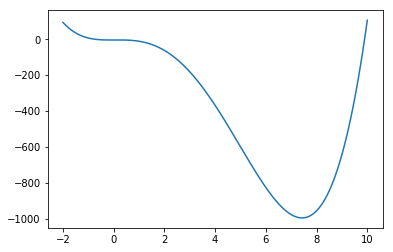

In [4]:
x = numpy.linspace(-2,10,1000)
pylab.plot(x,f(x))

Let's find the minimum, using 0 as a starting point:

In [5]:
print(fmin_bfgs(f, x0=0))

Optimization terminated successfully.
         Current function value: -4.093250
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 8
[-0.15101746]


We can suppress the messages using disp=False:

In [6]:
print(fmin_bfgs(f, x0=0, disp=False))

[-0.15101746]


### Exercise 4.1
Looks like we got stuck in a local miniumum. Print the values of the x where f(x) has a minimum findable from the following starting points: -2, 0, 2, 6, 10

In [7]:
# .............................
for x0 in [-2, 0, 2, 6, 10]:
    x_min = fmin_bfgs(f, x0=x0, disp=False)
    print("Starting at {} found minimum at {}".format(x0,x_min))

Starting at -2 found minimum at [-0.15101775]
Starting at 0 found minimum at [-0.15101746]
Starting at 2 found minimum at [7.42815758]
Starting at 6 found minimum at [7.42815774]
Starting at 10 found minimum at [7.4281578]



We can also use `fmin_bfgs` to minimize functions which take vectors rather than single numbers. For example, let's find the $x_1$ and $x_2$ which minimize the function $g(\mathbf{x}) = x_1^2 + x_2^2$ .

In [8]:
def g(x):
    return (x**2).sum()
x0 = numpy.array([-1, -1])
x1 = numpy.array([1,1])
print("Starting at {} found minimum at {}".format(x0, fmin_bfgs(g, x0=x0, disp=False)))
print("Starting at {} found minimum at {}".format(x0, fmin_bfgs(g, x0=x1, disp=False)))

Starting at [-1 -1] found minimum at [-7.13245452e-09 -7.13245452e-09]
Starting at [-1 -1] found minimum at [-1.07505143e-08 -1.07505143e-08]


### Exercise 4.2

In this exercise we will regress the fourth feature of the iris dataset agains the first three, using error function minimization. First prepare the data:

In [9]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
X_train, X_val, y_train, y_val = train_test_split(iris.data[:,:3], 
                                                  iris.data[:,3], 
                                                  test_size=1/3, 
                                                  random_state=666)

Now define the error function:

In [10]:
def error(wb):
    '''Returns the error as a function of intercept and coefficients'''
    # We'll get the intercept as the fist element of wb, and the coefficients as the rest
    b = wb[0]
    w = wb[1:]
    # complete the function by returning the sum squared error 
    # .........................................
    return numpy.sum((X_train.dot(w)+b - y_train)**2)

Let's define a starting point for the intercept and coefficients

In [11]:
# First item is the intercept b, the rest the coefficients w
wb0 = numpy.array([0.0, 0.0, 0.0, 0.0])
#................................

Now we are ready to find the values which minimize the error.

In [13]:
wb_min = fmin_bfgs(error, x0=wb0)
print(wb_min)

Optimization terminated successfully.
         Current function value: 2.860360
         Iterations: 5
         Function evaluations: 54
         Gradient evaluations: 9
[-0.27899144 -0.22846333  0.2540934   0.53891498]


### Exercise 5.3

Let's check how well these parameters do on validation data, in terms of mean absolute error and r-squared. 

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error
# ..........................................

y_val_pred = X_val.dot(wb_min[1:])+wb_min[0]
print(mean_absolute_error(y_val, y_val_pred))
print(r2_score(y_val, y_val_pred))

0.167757997204
0.914864382525


### Exercise 4.4
Let us compare these results with the classic implementation of linear regression

In [16]:
from sklearn.linear_model import LinearRegression
#.........................
model = LinearRegression()
model.fit(X_train, y_train)

print(model.intercept_, model.coef_)
# 
print(mean_absolute_error(y_val, model.predict(X_val)))
print(r2_score(y_val, model.predict(X_val)))

-0.278995856785 [-0.22846195  0.25409292  0.53891441]
0.167758010212
0.914864399764


## Stochastic Gradient Descent

Scikit learn provides two classes `SGDRegressor` and `SGDClassifier` which use stochastic gradient descent to carry out linear regression and classification respectively.

These models are especially useful in these situations:
- with very large datasets
- with streaming data (they support online learning)
- with datasets with sparse features

SGD is sensitive to learning rate and the scale of the features. It's advisable to z-score the features, and to tune the learning rate.

In [19]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

We'll use the dataset of 50,000 songs. The prediction task is to guess the year the song was made based on 90 timbre features extracted from the audio. The year is in the first column.

In [21]:
songs = numpy.load("songs50k.npy")
X_train, X_val, y_train, y_val = train_test_split(songs[:,1:], songs[:,0], test_size=1/3, random_state=666)

### Exercise 4.5

Train and evaluate the SGD classifier on the songs dataset. Take the following steps:
- z-score the training and validation features
- find good settings for learning rate type and learning rate initial value.
  - r-squared on validation data 
  - mean absolute error on validation data  

In [23]:
# .........................................
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z  =scaler.fit_transform(X_val)

lr = [ 10 ** x for x in range(-6,1)]

settings = []

for learning_rate in ['constant', 'optimal', 'invscaling']:
    for eta0 in lr:
        model = SGDRegressor(learning_rate=learning_rate, eta0=eta0, random_state=666)
        model.fit(X_train_z, y_train)
        mae = mean_absolute_error(y_val, model.predict(X_val_z))
        r2 =  r2_score(y_val, model.predict(X_val_z))
        settings.append((learning_rate, eta0, mae, r2))
        print(settings[-1])
best_mae = min(settings, key=lambda x: x[-2])
best_r2 =  max(settings, key=lambda x: x[-1])
print("Best settings according to MAE {}".format(best_mae))
print("Best settings according to R2 {}".format(best_r2))

('constant', 1e-06, 1691.6939047040719, -25740.804940849972)
('constant', 1e-05, 377.32239506868206, -1280.4988745664509)
('constant', 0.0001, 6.7552439908788076, 0.20507505576959972)
('constant', 0.001, 7.0750764405253479, 0.15984736302556612)
('constant', 0.01, 90158067960.919235, -1.5148066821158011e+20)
('constant', 0.1, 3375831007998.2964, -2.094275424205043e+23)
('constant', 1, 36922938309950.508, -2.4835485588743885e+25)
('optimal', 1e-06, 2175674618252.7292, -9.1619072805100201e+22)
('optimal', 1e-05, 2175674618252.7292, -9.1619072805100201e+22)
('optimal', 0.0001, 2175674618252.7292, -9.1619072805100201e+22)
('optimal', 0.001, 2175674618252.7292, -9.1619072805100201e+22)
('optimal', 0.01, 2175674618252.7292, -9.1619072805100201e+22)
('optimal', 0.1, 2175674618252.7292, -9.1619072805100201e+22)
('optimal', 1, 2175674618252.7292, -9.1619072805100201e+22)
('invscaling', 1e-06, 1976.6342530096438, -35142.481969525528)
('invscaling', 1e-05, 1790.3683811622066, -28831.300535871447)


### Exercise 4.6

By default SGDRegressor tries to minimize the standard linear regression error function, that is sum of squared error. However this can be changed, via the `loss=` parameter. When `loss='squared_loss'`, sum of squared errors will be used. Other error functions available include [Huber loss](https://en.wikipedia.org/wiki/Huber_loss) (`loss='huber'`). Compared to squared loss, huber focuses less on outliers.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Huber_loss.svg/600px-Huber_loss.svg.png)

Repeat the steps from the previous exercise, but include the tuning of the loss function.

In [18]:
#................................................
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train)
X_val_z  =scaler.fit_transform(X_val)

lr = [ 10 ** x for x in range(-6,1)]

settings = []

for learning_rate in ['constant', 'optimal', 'invscaling']:
  for loss in ['squared_loss', 'huber']:
    for eta0 in lr:
        model = SGDRegressor(learning_rate=learning_rate, eta0=eta0, loss=loss, random_state=666)
        model.fit(X_train_z, y_train)
        mae = mean_absolute_error(y_val, model.predict(X_val_z))
        r2 =  r2_score(y_val, model.predict(X_val_z))
        settings.append((learning_rate, eta0, loss, mae, r2))
        print(settings[-1])
best_mae = min(settings, key=lambda x: x[-2])
best_r2 =  max(settings, key=lambda x: x[-1])
print("Best settings according to MAE {}".format(best_mae))
print("Best settings according to R2 {}".format(best_r2))

/usr/lib/python3/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


('constant', 1e-06, 'squared_loss', 1691.6939047040719, -25740.804940849972)
('constant', 1e-05, 'squared_loss', 377.32239506868206, -1280.498874566451)
('constant', 0.0001, 'squared_loss', 6.755243990878808, 0.20507505576959972)
('constant', 0.001, 'squared_loss', 7.075076440525348, 0.15984736302556612)
('constant', 0.01, 'squared_loss', 90158067960.91924, -1.514806682115801e+20)
('constant', 0.1, 'squared_loss', 3375831007998.2964, -2.094275424205043e+23)
('constant', 1, 'squared_loss', 36922938309950.51, -2.4835485588743885e+25)
('constant', 1e-06, 'huber', 1998.4742436817962, -35923.35821099075)
('constant', 1e-05, 'huber', 1998.3242451817932, -35917.96584966415)
('constant', 0.0001, 'huber', 1996.8242601817703, -35864.064497347186)
('constant', 0.001, 'huber', 1981.824410182078, -35327.27706924383)
('constant', 0.01, 'huber', 1831.8259102310358, -30182.01248012661)
('constant', 0.1, 'huber', 331.84091416308604, -990.5670872853742)
('constant', 1, 'huber', 9.832523470409532, -0.619